In [6]:
# The code is developed for the paper "Customer Segmentation Applied On RFM-ID Model"

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from minisom import MiniSom
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import logsumexp

# Loading Data 

~ Data Description ~

InvoiceNo(Nominal): A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

StockCode(Nominal): Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. 

Description(String):  Product (item) name. 

Quantity(Numeric): The quantities of each product (item) per transaction.

InvoiceDate(Numeric): Invoice date and time. The day and time when a transaction was generated. 

UnitPrice(Numeric): Product price per unit in sterling (Â£). 

CustomerID(Nominal): A 5-digit integral number uniquely assigned to each customer. 

Country(Nominal): The name of the country where a customer resides.



In [4]:
df_c = pd.read_csv('./data/online_retail.csv')

In [5]:
print(f"Number of records: {df_c.shape[0]}")

Number of records: 1067371


In [6]:
df_c.head(10)

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [7]:
df_c.describe()

,Unnamed: 0,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,1.067371e+06,824364.000000
mean,2.669056e+05,9.938898e+00,4.649388e+00,15324.638504
std,1.541715e+05,1.727058e+02,1.235531e+02,1697.464450
min,0.000000e+00,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.334210e+05,1.000000e+00,1.250000e+00,13975.000000
50%,2.668420e+05,3.000000e+00,2.100000e+00,15255.000000
75%,4.002635e+05,1.000000e+01,4.150000e+00,16797.000000
max,5.419090e+05,8.099500e+04,3.897000e+04,18287.000000


In [8]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Unnamed: 0   1067371 non-null  int64  
 1   Invoice      1067371 non-null  object 
 2   StockCode    1067371 non-null  object 
 3   Description  1062989 non-null  object 
 4   Quantity     1067371 non-null  int64  
 5   InvoiceDate  1067371 non-null  object 
 6   Price        1067371 non-null  float64
 7   Customer ID  824364 non-null   float64
 8   Country      1067371 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 73.3+ MB


# Pre-processing

## Removing Null values

In [9]:
null_values_percentage = round(100*(df_c.isnull().sum())/len(df_c), 2)

In [10]:
null_values_percentage

Unnamed: 0      0.00
Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [11]:
# As we see custoemr ID has around 22% percent of null values. We are will drop these columns.

In [12]:
df_proc = df_c.dropna() # pre-processed data frame (data_proc)

In [13]:
df_proc.describe()

,Unnamed: 0,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000,824364.000000
mean,271491.670034,12.414574,3.676800,15324.638504
std,150554.198006,188.976099,70.241388,1697.464450
min,0.000000,-80995.000000,0.000000,12346.000000
25%,143189.750000,2.000000,1.250000,13975.000000
50%,275354.500000,5.000000,1.950000,15255.000000
75%,400531.250000,12.000000,3.750000,16797.000000
max,541909.000000,80995.000000,38970.000000,18287.000000


## Removing Negative values

In [14]:
df_proc = df_proc[~df_proc["Invoice"].str.contains("C", na = False)]

## Removing Outliers

In [20]:
df_proc[["Quantity", "Price"]]

,Quantity,Price
0,12,6.95
1,12,6.75
2,12,6.75
3,48,2.10
4,24,1.25
...,...,...
541905,6,2.10
541906,4,4.15
541907,4,4.15
541908,3,4.95


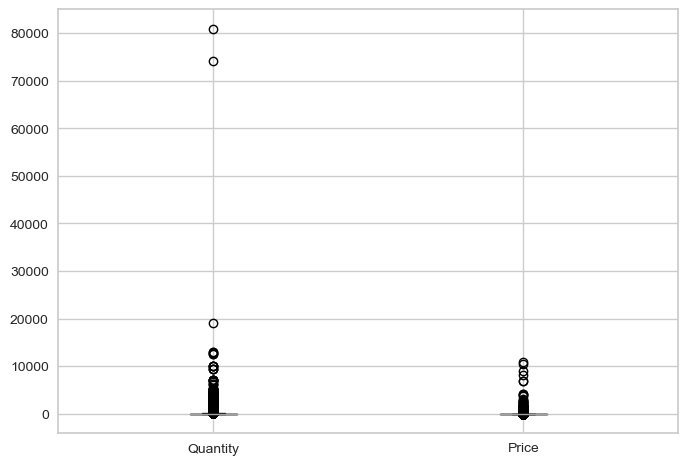

In [21]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [22]:
# As we see, Quantity and Price have outliers. So, we will remove them.

In [23]:
# Removing outliers from the Quantity attribute
Q1 = df_proc.Quantity.quantile(0.25)
Q3 = df_proc.Quantity.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Quantity>lower_limit)&(df_proc.Quantity<upper_limit)]


In [24]:
# Removing outliers from the Price attribute
Q1 = df_proc.Price.quantile(0.25)
Q3 = df_proc.Price.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Price>lower_limit)&(df_proc.Price<upper_limit)]


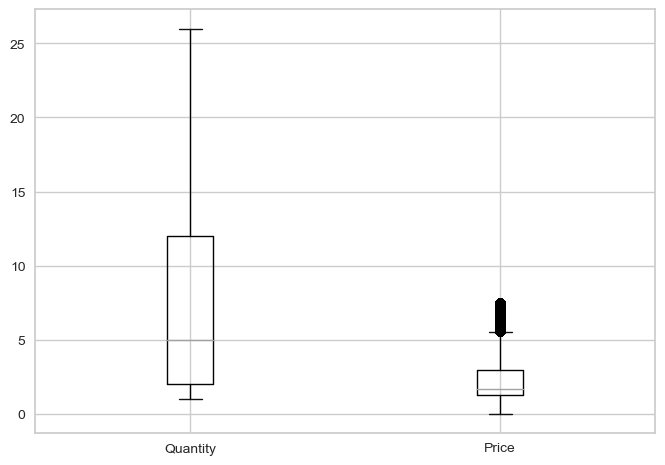

In [25]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [26]:
df_proc.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,686023.000000,686023,686023.000000,686023.000000
mean,7.299531,2011-01-02 12:08:08.844630784,2.269788,15362.101306
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-07-06 13:55:00,1.250000,14019.000000
50%,5.000000,2010-12-03 11:35:00,1.690000,15311.000000
75%,12.000000,2011-07-31 14:29:00,2.950000,16841.000000
max,26.000000,2011-12-09 12:50:00,7.490000,18287.000000
std,6.692578,NaN,1.599637,1694.422894


# RFMVD Score

R(Recenecy): How recently did the customer purchase?

F(Frequency): How often do they purchase?

M(Monetary): How much do they spend?

V(Variety): How many products sold by each customer?

D(Duration): How much time between each two transactions?

In [27]:
# Numbber of descriptions per product for each StockCode.
df_proc.groupby('StockCode').agg({'Description': "nunique"}).sort_values(by='Description', ascending=False).head()

,Description
StockCode,
21955,4
22346,4
22345,4
22344,4
23196,4


In [28]:
# From the above table we can see that each StockCode has more than one description. This is maybe because of non-standard human input.

## RFM

In [29]:
# Recency

# Max date
df_proc['InvoiceDate'] = pd.to_datetime(df_proc['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = df_proc['InvoiceDate'].max()
max_date

# Different between max date and the transaction date
df_proc['Diff'] = max_date - df_proc['InvoiceDate']

# Last transaction date for each customer
rfm_r = df_proc.groupby('Customer ID')['Diff'].min().reset_index()
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.columns =  ['Customer ID', 'Recency']
rfm_r.head(10)

,Customer ID,Recency
0,12346.0,528
1,12347.0,1
2,12348.0,248
3,12349.0,18
4,12350.0,309
5,12351.0,374
6,12352.0,35
7,12353.0,203
8,12354.0,231
9,12355.0,213


In [30]:
# Frequency
rfm_f = df_proc.groupby('Customer ID')['Invoice'].count().reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head(10)


,Customer ID,Frequency
0,12346.0,33
1,12347.0,234
2,12348.0,26
3,12349.0,137
4,12350.0,16
5,12351.0,20
6,12352.0,83
7,12353.0,22
8,12354.0,40
9,12355.0,29


In [31]:
# Monetary 
df_proc['Total'] = df_proc['Price'] * df_proc['Quantity']
rfm_m = df_proc.groupby('Customer ID')['Total'].sum().reset_index()
rfm_m.columns = ['Customer ID', 'Monetary']
rfm_m.head(10)

,Customer ID,Monetary
0,12346.0,372.86
1,12347.0,4538.90
2,12348.0,312.36
3,12349.0,2620.04
4,12350.0,294.40
5,12351.0,288.18
6,12352.0,1461.99
7,12353.0,347.06
8,12354.0,682.69
9,12355.0,656.11


In [32]:
# Creating the RFM data frame.
rfm = pd.merge(rfm_r, rfm_f, on='Customer ID', how='inner')
rfm = pd.merge(rfm, rfm_m, on='Customer ID', how='inner')
rfm.head(10)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,528,33,372.86
1,12347.0,1,234,4538.90
2,12348.0,248,26,312.36
3,12349.0,18,137,2620.04
4,12350.0,309,16,294.40
5,12351.0,374,20,288.18
6,12352.0,35,83,1461.99
7,12353.0,203,22,347.06
8,12354.0,231,40,682.69
9,12355.0,213,29,656.11


## VD

In [33]:
# Variety
def div(x: pd.Series):
    u = x.nunique()
    return u

rfm_v = df_proc.groupby('Customer ID')['StockCode'].agg([div]).reset_index()
rfm_v.columns = ['Customer ID', 'Variety']
rfm_v.head(10)

,Customer ID,Variety
0,12346.0,26
1,12347.0,119
2,12348.0,21
3,12349.0,110
4,12350.0,16
5,12351.0,20
6,12352.0,60
7,12353.0,21
8,12354.0,40
9,12355.0,29


In [34]:
# Duration

import statistics

def duration(x: pd.Series):
    m = []
    x = pd.to_datetime(x, format='%d-%m-%Y %H:%M')
    # print(x.iloc[0])
    for i in range(1, len(x)-1):
        diff =  x.iloc[i] - x.iloc[i - 1]
        m.append(diff.days)

    return statistics.mean(m) if m else 0

rfm_d= df_proc.groupby('Customer ID')['InvoiceDate'].agg([duration]).reset_index()
rfm_d.columns = ['Customer ID', 'Duration']
rfm_d.head(10)



,Customer ID,Duration
0,12346.0,6.193548
1,12347.0,1.719828
2,12348.0,4.958333
3,12349.0,4.222222
4,12350.0,0.000000
5,12351.0,0.000000
6,12352.0,4.358025
7,12353.0,10.200000
8,12354.0,0.000000
9,12355.0,13.074074


In [35]:
# Ceating the RFMVD data frame.
vd = pd.merge(rfm_v, rfm_d, on='Customer ID', how='inner')

rfmvd = pd.merge(rfm, vd, on='Customer ID', how='inner')
rfmvd.describe()

,Customer ID,Recency,Frequency,Monetary,Variety,Duration
count,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000,5678.000000
mean,15318.222437,200.019021,120.821240,1551.003284,74.122754,5.173586
std,1714.837549,208.931814,311.775018,3812.196055,104.713773,13.808916
min,12346.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,13837.250000,25.000000,18.000000,251.110000,17.000000,0.000000
50%,15318.500000,94.500000,47.000000,615.185000,40.000000,1.932077
75%,16801.750000,379.000000,123.000000,1566.280000,92.750000,5.215505
max,18287.000000,738.000000,12052.000000,176897.620000,2219.000000,471.000000


In [36]:
rfmvd.corr()

,Customer ID,Recency,Frequency,Monetary,Variety,Duration
Customer ID,1.000000,0.028031,0.009918,-0.040094,0.007932,-0.005308
Recency,0.028031,1.000000,-0.214235,-0.227478,-0.321802,-0.103890
Frequency,0.009918,-0.214235,1.000000,0.788310,0.867775,-0.081312
Monetary,-0.040094,-0.227478,0.788310,1.000000,0.717126,-0.065134
Variety,0.007932,-0.321802,0.867775,0.717126,1.000000,-0.126965
Duration,-0.005308,-0.103890,-0.081312,-0.065134,-0.126965,1.000000


## Scaling

In [37]:
scaler = StandardScaler()
# scaler =  MinMaxScaler()
rfmvd_tmp = rfmvd[['Recency', 'Frequency', 'Monetary', 'Variety', 'Duration']]
rfmvd_scaled = pd.DataFrame(scaler.fit_transform(rfmvd_tmp))
rfmvd_scaled.columns =['Recency', 'Frequency', 'Monetary', 'Variety', 'Duration']
rfmvd_scaled.head(20)

,Recency,Frequency,Monetary,Variety,Duration
0,1.569937,-0.281706,-0.309073,-0.459605,0.073869
1,-0.952639,0.363046,0.783842,0.428608,-0.250133
2,0.229669,-0.304160,-0.324945,-0.507359,-0.015589
3,-0.871265,0.051897,0.280450,0.342652,-0.068901
4,0.521656,-0.336238,-0.329656,-0.555112,-0.374688
5,0.832790,-0.323407,-0.331288,-0.516909,-0.374688
6,-0.789892,-0.121320,-0.023352,-0.134882,-0.059066
7,0.014269,-0.316991,-0.315841,-0.507359,0.364030
8,0.148296,-0.259252,-0.227793,-0.325896,-0.374688
9,0.062136,-0.294537,-0.234765,-0.430953,0.572180


# Segmentation Algorithms

## K-means

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

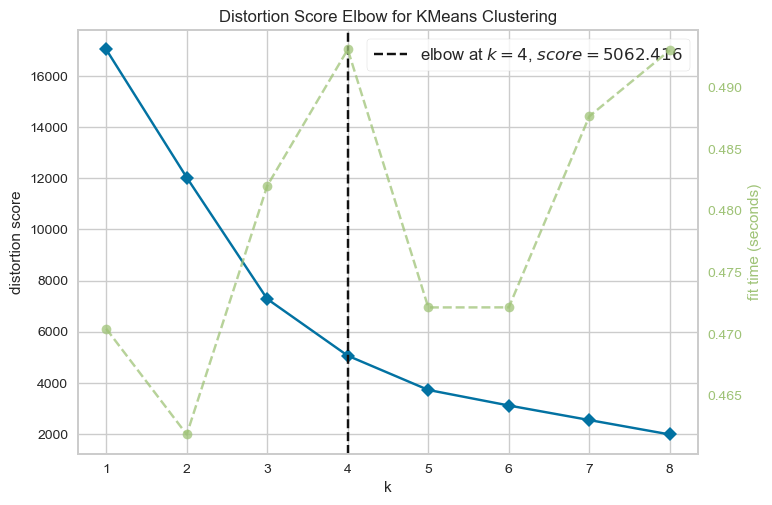

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [448]:
# RFM
vars = ['Recency', 'Frequency', 'Monetary']
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9))

visualizer.fit(rfmvd_scaled[vars])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [449]:
n = 4 # number of clusters

In [450]:
%%timeit -r1 -n1
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


473 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [451]:
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=500, n_clusters=4, random_state=1)

In [452]:
# RFM

cluster_labels = kmeans.labels_
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))



For n_clusters=4, the silhouette score is 0.5846561741869105
For n_clusters=4, the calinski score is 4472.584335852707
For n_clusters=4, the davis_bouldin score is 0.6700970894273075


In [453]:
kmeans.cluster_centers_

array([[-0.83057114,  1.81727117,  1.96530786],
       [ 1.27527923, -0.26333615, -0.284907  ],
       [-0.61153739, -0.06939875, -0.06602898],
       [-0.75159855, 17.30980617, 15.26386196]])

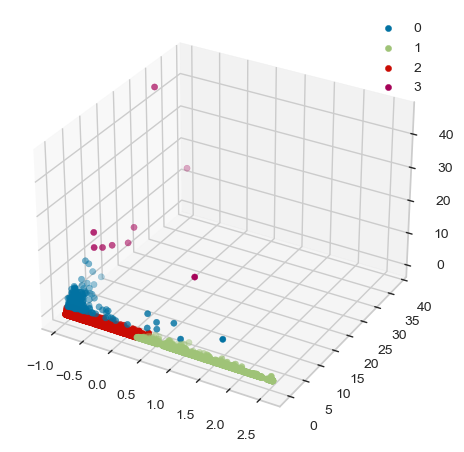

In [454]:
# RFM clustering graph
centroids = kmeans.cluster_centers_
u_labels = np.unique(cluster_labels)
ax = plt.axes(projection='3d')

#plotting the results:
for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd_scaled.Labels == i]['Recency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Frequency'] , rfmvd_scaled[rfmvd_scaled.Labels == i]['Monetary'], label = i, zorder=1)

 # plotting centroids
# ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], marker='x', 
#                 s=1, linewidths=10, color='b', label='centroid', zorder=100)
ax.legend()
plt.show()

In [455]:
centroids

array([[-0.83057114,  1.81727117,  1.96530786],
       [ 1.27527923, -0.26333615, -0.284907  ],
       [-0.61153739, -0.06939875, -0.06602898],
       [-0.75159855, 17.30980617, 15.26386196]])

In [456]:
n = 3
e = 0.8
s = 1000
double_cluster_df = pd.DataFrame()
centroids_n = []
for i in range(len(centroids)):
    kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
    rfm_i = rfmvd_scaled[vars].loc[rfmvd_scaled['Labels'] == i]
    kmeans.fit(rfm_i)
    # kmeans = AgglomerativeClustering(n_clusters=2)
    # kmeans.fit(rfm_i)
    labels = [l+(2*(i**2)) for l in kmeans.labels_] 
    sel_score = calinski_harabasz_score(rfm_i, labels)
    print(sel_score)
    if sel_score:
        rfm_i['Labels'] = labels
        # centroids_n.append(kmeans.cluster_centers_)
        double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)
    else:
        rfm_i['Labels'] = 2*(i**2)
        # centroids_n.append(kmeans.cluster_centers_)
        double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


197.49500453715186


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


2940.1238797249675


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3246.269316397096


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


20.192780838315322


In [457]:
# RFM

cluster_labels = double_cluster_df['Labels']
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(double_cluster_df[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(double_cluster_df[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(double_cluster_df[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))



For n_clusters=3, the silhouette score is 0.38104238058880685
For n_clusters=3, the calinski score is 3395.2254591432807
For n_clusters=3, the davis_bouldin score is 0.934402278844722


In [458]:
print(double_cluster_df.head(2400))

       Recency  Frequency  Monetary  Labels
0    -0.789892   0.712688  1.488044       0
1    -0.957425   1.290078  2.940112       0
2    -0.952639   1.043084  1.817537       0
3    -0.909559   0.930813  1.860521       0
4    -0.952639   2.569960  4.989080       1
...        ...        ...       ...     ...
2395 -0.411745  -0.361899 -0.373073       8
2396 -0.842545  -0.262460 -0.211769       9
2397  0.095642  -0.377938 -0.387665       8
2398 -0.339945  -0.076412  0.037553       8
2399 -0.799465   0.080767  0.371445      10

[2400 rows x 4 columns]


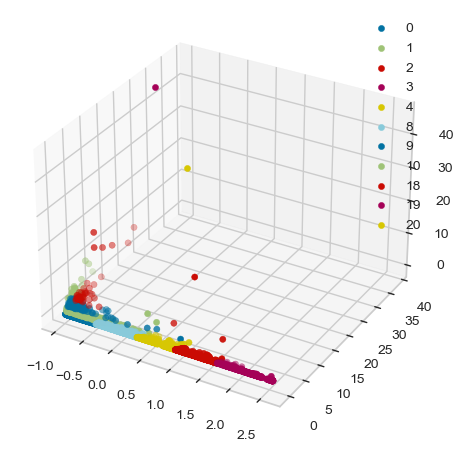

In [459]:
# RFM clustering graph
u_labels = np.unique(double_cluster_df["Labels"])

ax = plt.axes(projection='3d')

#plotting the results:
for i in u_labels:
    ax.scatter(double_cluster_df[double_cluster_df.Labels == i]['Recency'] , double_cluster_df[double_cluster_df.Labels == i]['Frequency'] , double_cluster_df[double_cluster_df.Labels == i]['Monetary'], label = i, zorder=1)

 # plotting centroids
# ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], marker='x', 
#                 s=1, linewidths=10, color='b', label='centroid', zorder=100)
ax.legend()
plt.show()

In [ ]:
# if sel_score:
    #     rfm_i['Labels'] = labels
    #     # centroids_n.append(kmeans.cluster_centers_)
    #     double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)
    # else:
    #     rfm_i['Labels'] = 2*(i**2)
    #     # centroids_n.append(kmeans.cluster_centers_)
    #     double_cluster_df = pd.concat([double_cluster_df, rfm_i], ignore_index=True)

In [ ]:
    # labels = [l+(2*(i**2)) for l in kmeans.labels_] # to give each group a unique label


# SOM

In [ ]:
som_shape = (2, 2)

In [ ]:
som = MiniSom(som_shape[0], som_shape[1], rfmvd_scaled[vars].shape[1], sigma=0.3, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10)
som.random_weights_init(rfmvd_scaled[vars].values)
som.train_random(rfmvd_scaled[vars].values, 100)

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in rfmvd_scaled[vars].values]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
cluster_labels = cluster_index
rfmvd_scaled['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))

For n_clusters=4, the silhouette score is 0.2876873478905792
For n_clusters=4, the calinski score is 891.9287502673657
For n_clusters=4, the davis_bouldin score is 1.2511280051817195


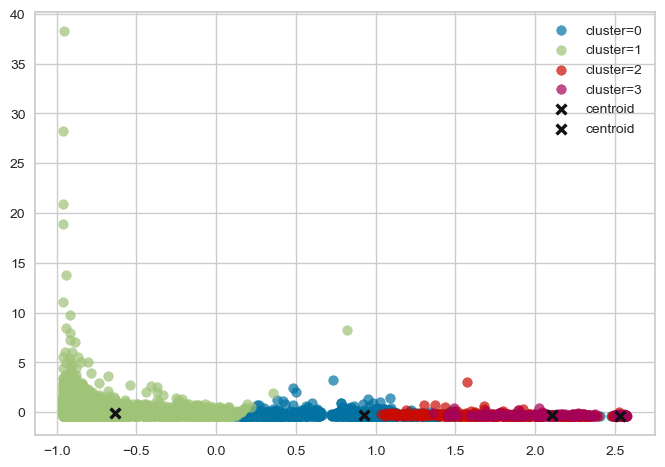

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(rfmvd_scaled[vars].values[cluster_index == c, 0],
                rfmvd_scaled[vars].values[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=3, linewidths=10, color='k', label='centroid')
plt.legend()

In [ ]:
# labels = [last_v+i+l for l in kmeans.labels_]
    # last_v = last_v + i + (nn-1)